# Are the TRAPPIST-1 flares associated with bright regions?

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

Remove outlier fluxes, mask out flares, median filter the light curve (5 cadence kernel)

In [91]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist_everest_luger.fits')
k2_time, k2_flux = f['TIME'][:-100] + 2454833, f['FLUX'][:-100], 

# Mask out strange fluxes
k2_flux /= np.median(k2_flux)

k2_time = k2_time[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)]
k2_flux = k2_flux[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)] 

p = np.polyfit((k2_time - k2_time.mean()), k2_flux, 5)
k2_flux -= np.polyval(p, k2_time - k2_time.mean())

flare_times = np.loadtxt('flare_times.txt')
during_flares = np.any(np.abs(k2_time - flare_times[:, np.newaxis]) < 0.1, axis=0)

k2_time = k2_time[~during_flares]
k2_flux = k2_flux[~during_flares]

from scipy.signal import medfilt

k2_flux = medfilt(k2_flux, (5,))

k2_error = np.ones_like(k2_flux) * np.std(k2_flux)/3

Model the K2 light curve with a SHO kernel from `celerite`:

In [96]:
import celerite
from celerite import terms

kernel = terms.SHOTerm(-11.60656534,  -2.43609442,   2.52251431)

gp = celerite.GP(kernel, mean=np.mean(k2_flux))
gp.compute(k2_time, k2_error)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(k2_flux)))

Initial log likelihood: 18679.720011517435


In [97]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(k2_flux, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -18813.070166375954
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01346052, -0.0170985 , -0.01491571])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 12
   status: 0
  success: True
        x: array([-11.84713947,  -1.16351291,   1.43397978])


In [102]:
x = np.arange(k2_time.min(), k2_time.max(), 1/24)
pred_mean, pred_var = gp.predict(k2_flux, x, return_var=True)

gp_model = gp.predict(k2_flux, k2_time)

pred_std = np.sqrt(pred_var)

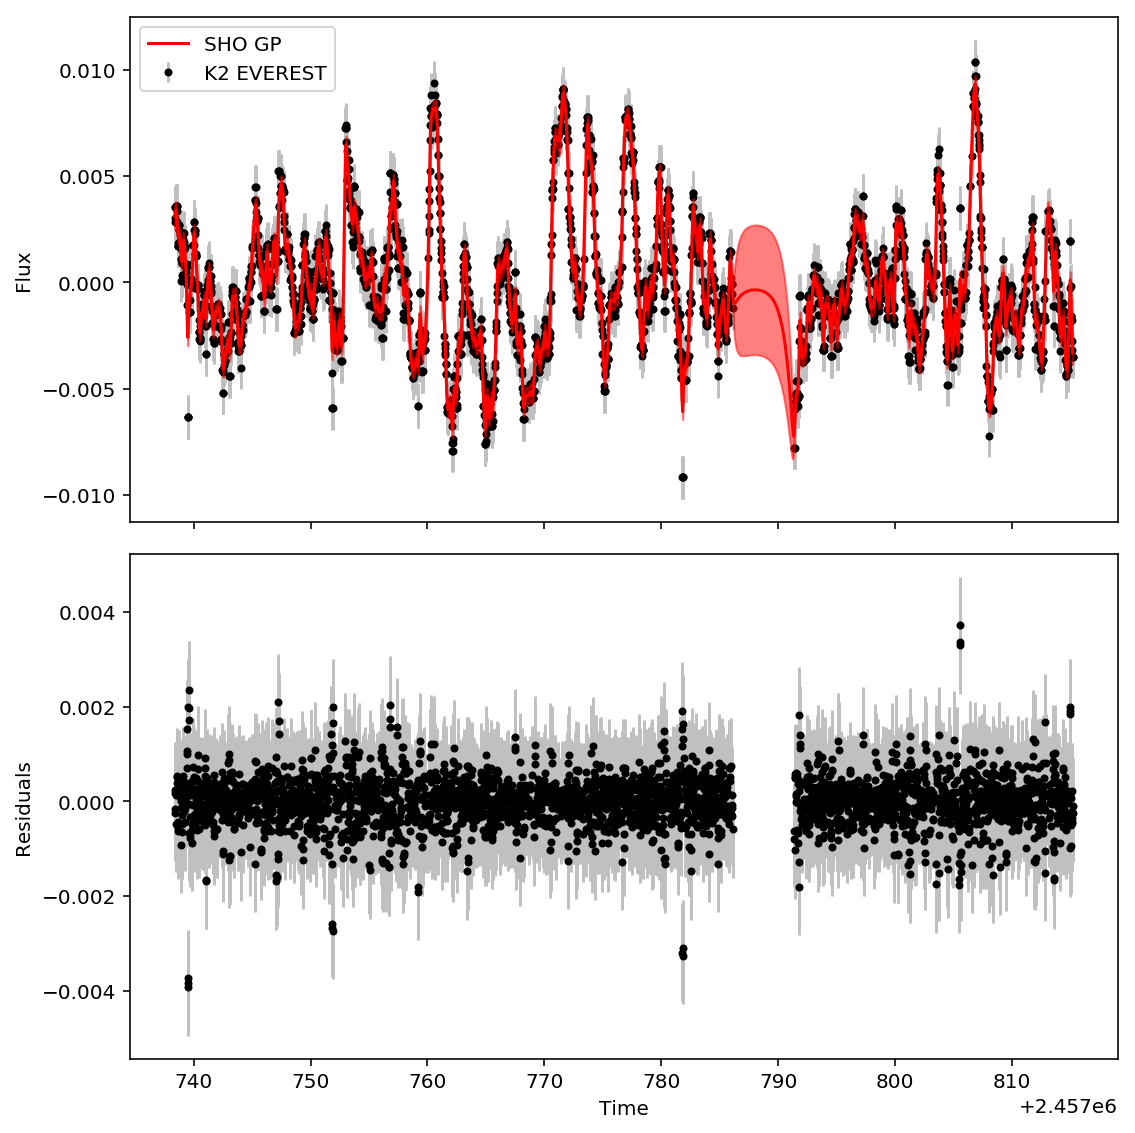

In [125]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)#figsize=(14, 6))
ax[0].errorbar(k2_time, k2_flux, k2_error, fmt='.', color='k', ecolor='silver', label='K2 EVEREST', zorder=-10)

ax[0].plot(x, pred_mean, 'r', label='SHO GP')
ax[0].fill_between(x, pred_mean + pred_std, pred_mean - pred_std, color='r', alpha=0.5,
                   edgecolor="none")

ax[1].errorbar(k2_time, k2_flux - gp_model[0], k2_error, fmt='.', color='k', ecolor='silver',)
ax[0].set(ylabel='Flux')
ax[0].legend()
ax[1].set(xlabel='Time', ylabel='Residuals')
fig.tight_layout()
fig.savefig('flare_gp_model.pdf', bbox_inches='tight')

In [108]:
gp_model_flares = gp.predict(k2_flux, flare_times)[0]

Text(0.5,0,'Residual flux')

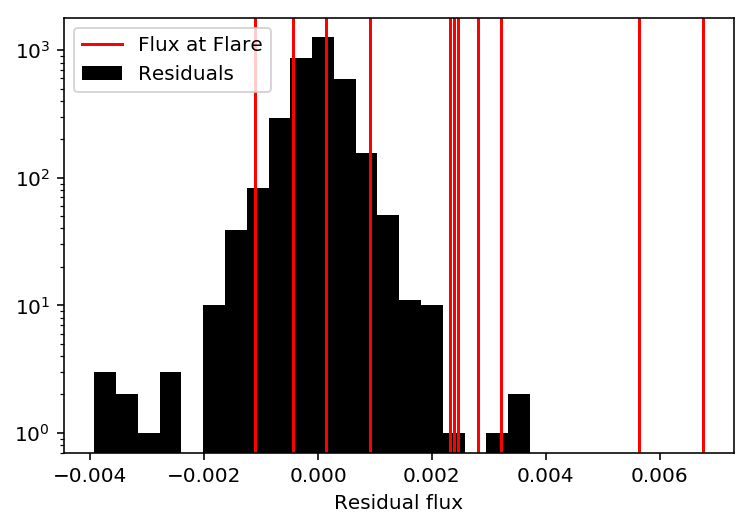

In [139]:
n, bins, _ = plt.hist(k2_flux - gp_model[0], bins=20, log=True, color='k', label='Residuals')
for i, gpf in enumerate(gp_model_flares):
    if i == 0: 
        plt.axvline(gpf, color='r', label='Flux at Flare')
    else: 
        plt.axvline(gpf, color='r')
# plt.hist(gp_model_flares, log=True, bins=bins, color='r')
plt.legend()
plt.xlabel('Residual flux')

Is the distribution of fluxes at the times of flares have a statistically different mean than the rest of the residuals?

In [140]:
from scipy.stats import ttest_ind

ttest_ind(k2_flux - gp_model[0], gp_model_flares)

Ttest_indResult(statistic=-14.082545679411616, pvalue=8.1613989657810485e-44)

$p \sim 10^{-44}$ is a resounding *yes*, the flares occur at times of higher flux. 